In [1]:
# loading the necessary libraries
import pandas as pd
from scipy.stats import zscore
import numpy as np

# loading and displaying the PIMA Diabetes dataset
df = pd.read_csv("diabetes.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [2]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Data Cleaning

In [3]:
# checking for duplicates
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")

# viewing the duplicate rows
duplicate_rows = df[duplicates]
print(duplicate_rows)

Number of duplicate rows: 0
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []


In [4]:
# checking for class balance
class_counts = df['Outcome'].value_counts()
class_percentages = df['Outcome'].value_counts(normalize=True) * 100

print(" Class Counts:\n", class_counts)
print("\n Class Percentages:\n", class_percentages)

 Class Counts:
 Outcome
0    500
1    268
Name: count, dtype: int64

 Class Percentages:
 Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


### Why Use SMOTE for Class Balancing?

The original dataset shows a moderate class imbalance:
- Non-diabetic (Outcome = 0): ~65%
- Diabetic (Outcome = 1): ~35%

This imbalance can bias models like Logistic Regression towards the majority class, leading to high accuracy but poor recall on the minority class — which is risky in medical predictions where false negatives are costly.

To address this, we use **SMOTE (Synthetic Minority Oversampling Technique)**:
- SMOTE generates **synthetic samples** for the minority class by interpolating between existing observations.
- This avoids simple duplication and helps the model learn a more **generalizable boundary** for the minority class.

**Why it's a good fit here?**
1. SMOTE assumes the feature space is continuous and metric. Therefore, it can compute distances between data points.
2. Severe imbalance (90:10) requires more aggressive techniques, such as combining SMOTE with undersampling the majority class.

In [5]:
from imblearn.over_sampling import SMOTE

# selecting the features
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X = df[features]
y = df['Outcome']

# applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# combining the balanced datasets back
df = pd.DataFrame(X_balanced, columns=features)
df['Outcome'] = y_balanced

# checking the balanced dataset
print("New class distribution after SMOTE:\n", y_balanced.value_counts())

New class distribution after SMOTE:
 Outcome
1    500
0    500
Name: count, dtype: int64


In [6]:
# calculating z-scores for all numerical features
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))

# flagging outliers where z-score > 3
outlier_mask = (z_scores > 3)
outliers = (outlier_mask).sum()

# showing the number of outliers per feature
outlier_summary = pd.Series(outliers, index=df.columns).sort_values(ascending=False)
print("Outliers per feature (Z-score > 3):")
print(outlier_summary)

Outliers per feature (Z-score > 3):
BloodPressure               51
Insulin                     25
BMI                         15
DiabetesPedigreeFunction    14
Age                          6
Glucose                      5
Pregnancies                  4
SkinThickness                2
Outcome                      0
dtype: int64


Logistic Regression is sensitive to outliers, which can distort its decision boundary. Instead of removing rows — which might discard valid but extreme medical cases — I applied **log transformation** to skewed features. Since the dataset contains no negative values, log-scaling is a safe and effective choice.

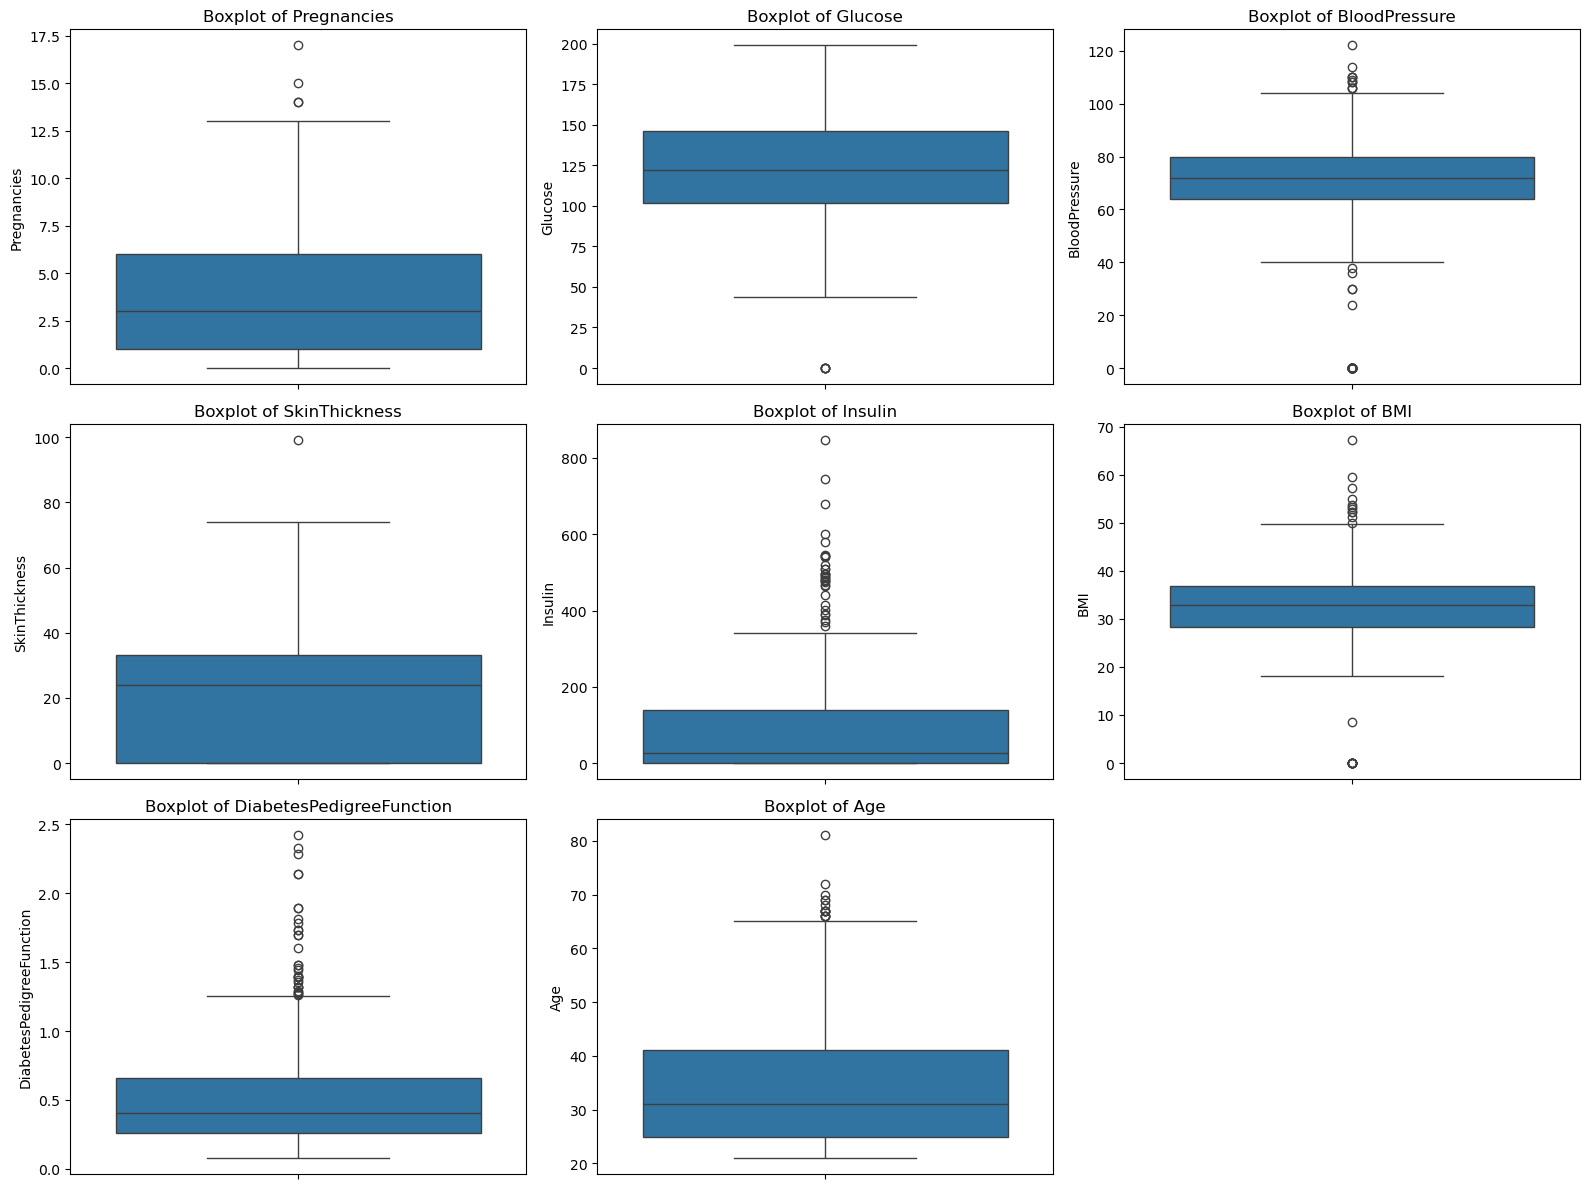

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# plotting boxplots for all features
plt.figure(figsize=(16, 12))
for i, column in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

In [8]:
# applying log(1 + x) transformation to skewed features
features_to_log = ['Insulin', 'BMI', 'DiabetesPedigreeFunction', 'BloodPressure']

for feature in features_to_log:
    df[f'{feature}_log'] = np.log1p(df[feature])

# showing the transformed features
df[[f'{f}_log' for f in features_to_log]].head()

,Insulin_log,BMI_log,DiabetesPedigreeFunction_log,BloodPressure_log
0,0.000000,3.543854,0.486738,4.290459
1,0.000000,3.317816,0.300845,4.204693
2,0.000000,3.190476,0.514021,4.174387
3,4.553877,3.370738,0.154436,4.204693
4,5.129899,3.786460,1.190279,3.713572


# Data Visualization

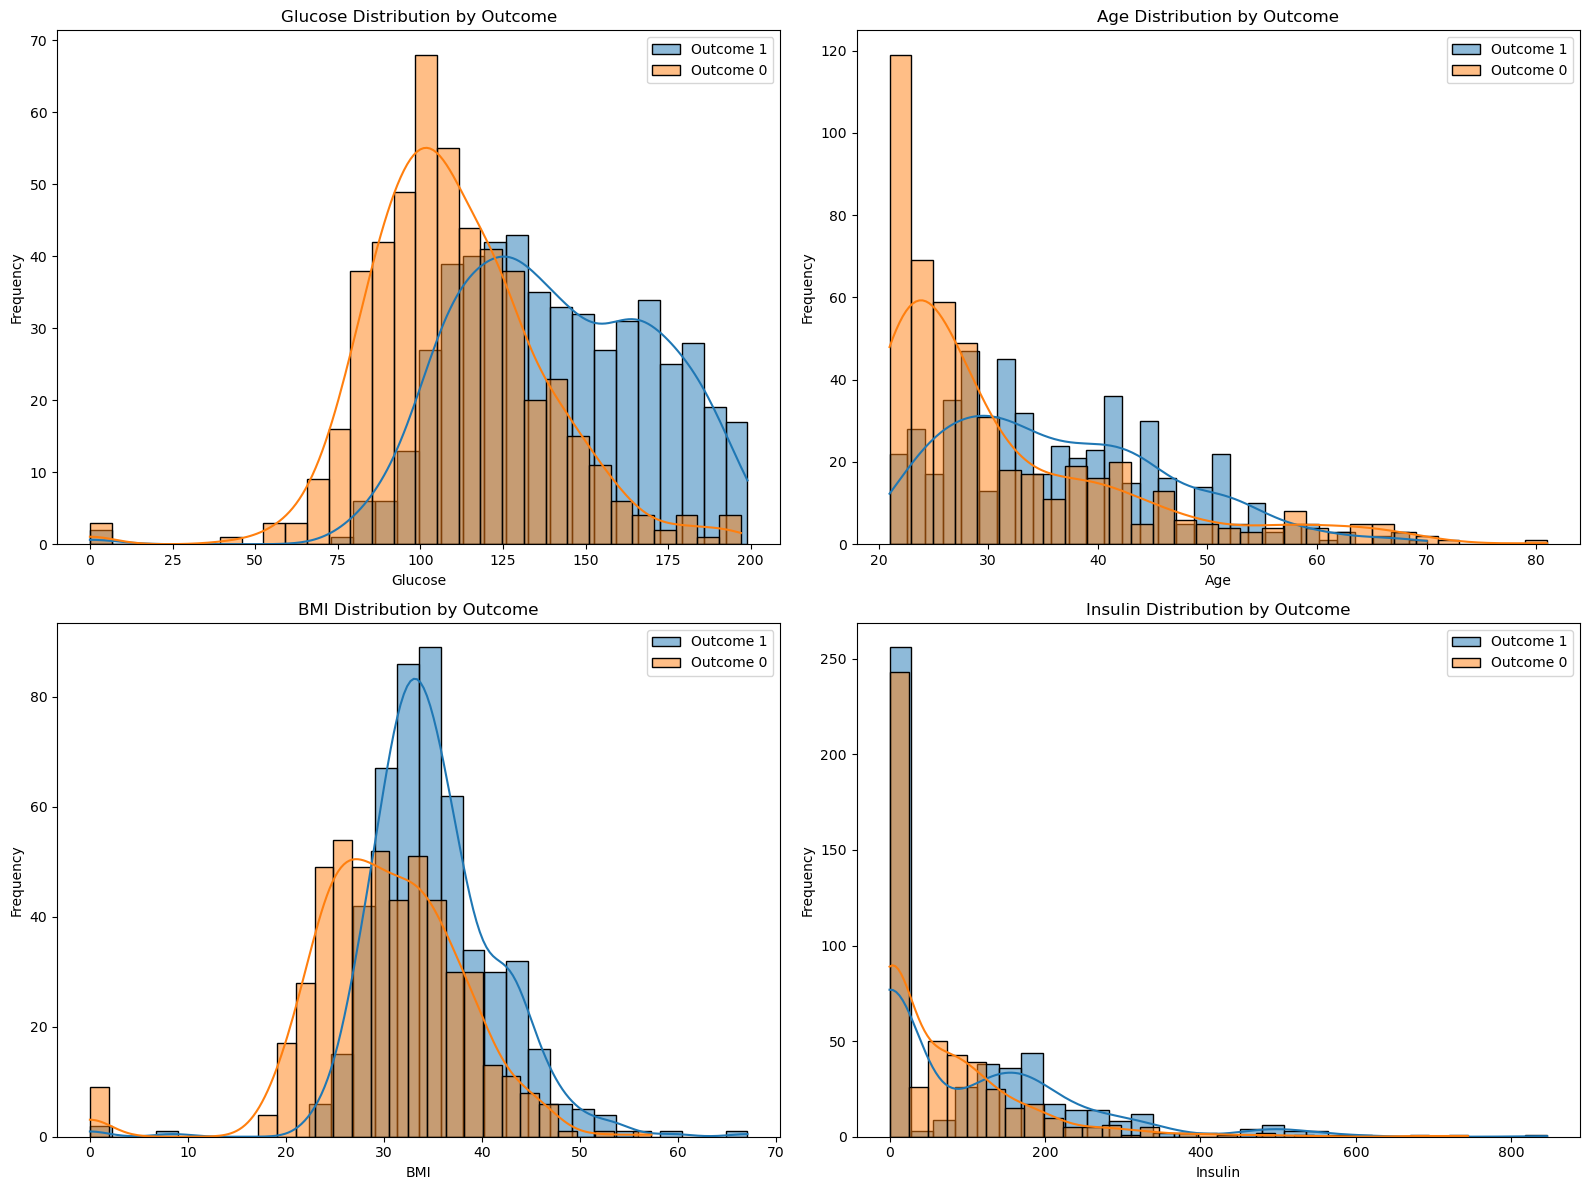

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['Glucose', 'Age', 'BMI', 'Insulin']
plt.figure(figsize=(16, 12))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    for cls in df['Outcome'].unique():
        subset = df[df['Outcome'] == cls]
        sns.histplot(subset[feature], bins=30, kde=True, label=f'Outcome {cls}', alpha=0.5)
    plt.title(f'{feature} Distribution by Outcome')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

**Interpretation of Feature Distributions with Respect to Diabetes Outcome**

1. _**Glucose vs. Outcome**_
The glucose levels for non-diabetic individuals appear to follow a near-normal distribution, clustering around 100 mg/dL — a healthy range.
However, for the diabetic group, the distribution shifts notably to the right and flattens, indicating higher glucose levels with a wider spread. This reinforces the biological reality - once diagnosed with diabetes, it's often challenging to maintain low or normal blood sugar levels.

2. _**Age vs. Outcome**_
The age distribution reveals a strong right skew, especially for non-diabetic individuals. This suggests that the dataset contains a disproportionately large number of younger, non-diabetic participants, possibly due to sampling bias or real-world demographic trends. That said, the diabetic population is more evenly spread across older age brackets, with a slow decline as age increases — consistent with the fact that the risk of diabetes increases with age.

3. _**BMI vs. Outcome**_
Interestingly, both diabetic and non-diabetic populations show a normal distribution for BMI, but with different peaks:
- Non-diabetic individuals peak around a BMI of 30
- Diabetic individuals peak slightly higher, around BMI 35.
This small but an important shift emphasizes the well-established correlation between higher BMI and diabetes risk, even though the overall shape of the distribution remains consistent.

5. _**Insulin vs. Outcome**_
Among non-diabetic individuals, insulin values gradually taper off — a long right tail without a clear peak. For diabetic individuals, the distribution has more structure, peaking moderately, yet still includes a substantial number of individuals with zero insulin values, possibly indicating missing or imputed data. This contrast suggests either poor insulin regulation in diabetics or issues in data collection/entry that need further scrutiny.

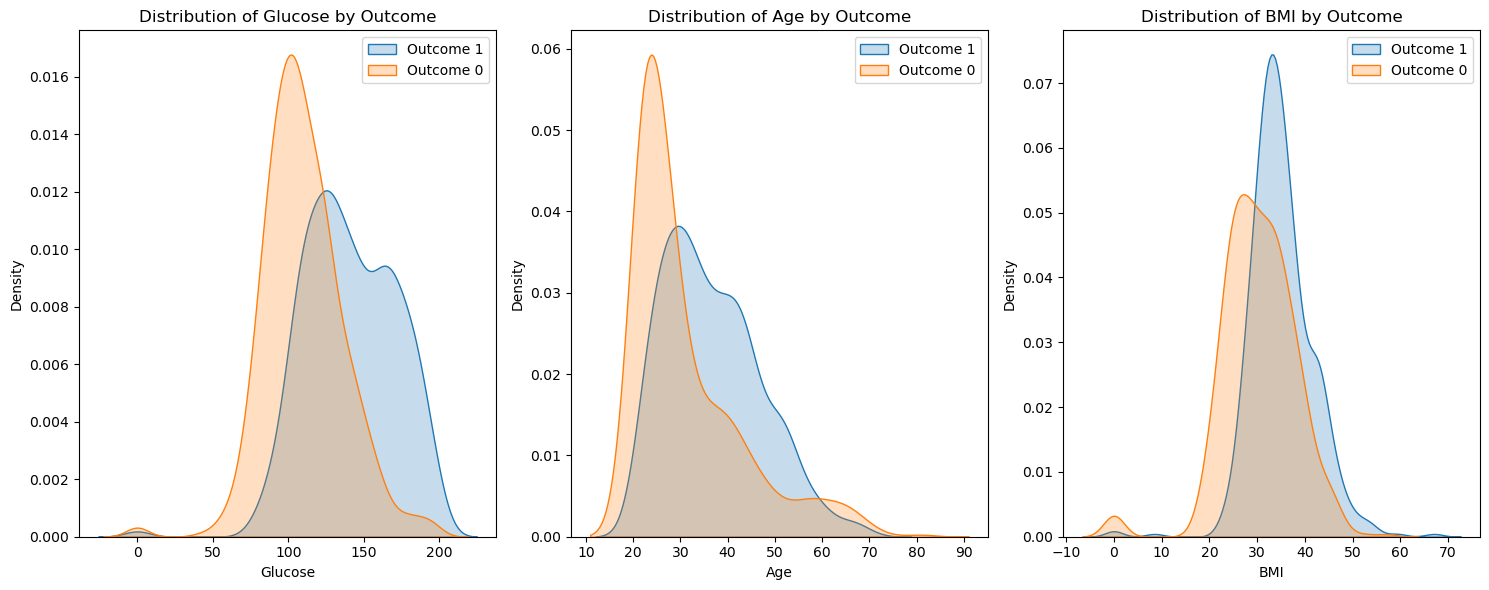

In [10]:
features = ['Glucose', 'Age', 'BMI']
plt.figure(figsize=(15, 6))
for i, feature in enumerate(features, 1):
    plt.subplot(1, 3, i)
    for cls in df['Outcome'].unique():
        subset = df[df['Outcome'] == cls]
        sns.kdeplot(subset[feature], label=f'Outcome {cls}', fill=True)
    plt.title(f'Distribution of {feature} by Outcome')
    plt.legend()
plt.tight_layout()
plt.show()

**Is glucose consistently higher in diabetics?**

Yes, absolutely! The KDE plot clearly shows that the diabetic population (Outcome 1) has a right-shifted glucose distribution compared to non-diabetics.
The peak for non-diabetics sits around 100 mg/dL, whereas diabetics frequently exceed 130–150 mg/dL. This supports the medical reality that glucose is one of the strongest indicators of diabetes and confirms it is a top feature for prediction.

**Does age matter more than BMI?**

Age is heavily skewed to the left with most non-diabetic participants being younger. The diabetic curve is flatter and spans more broadly across age groups, especially beyond 30–40 years. BMI, on the other hand, shows two overlapping but slightly separated curves. Diabetics skew just a bit higher in BMI but not dramatically. In conclusion, age shows a stronger class separation than BMI in this plot, but both provide some signal.

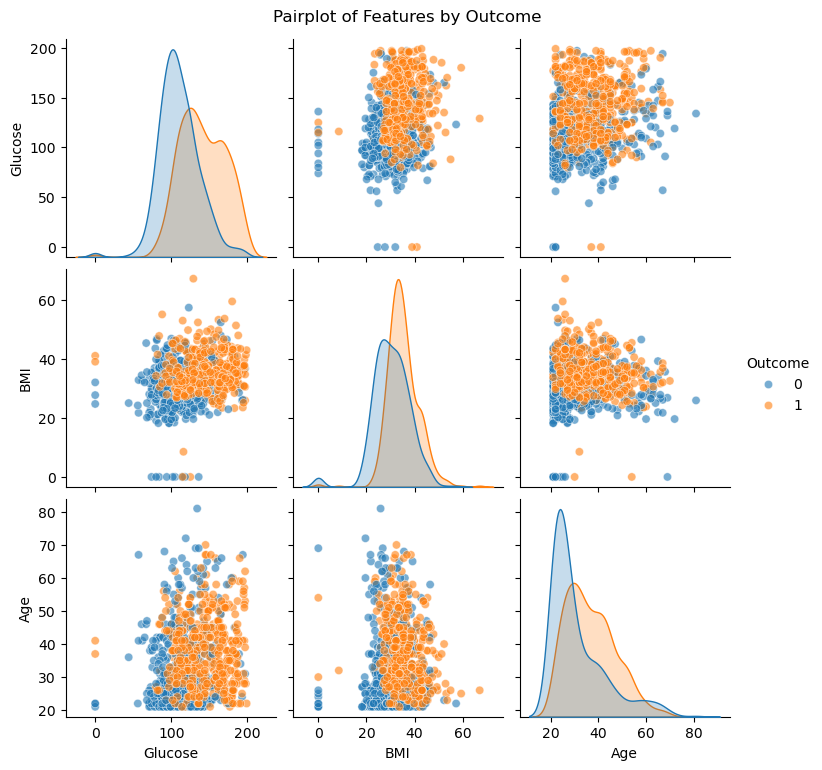

In [11]:
sns.pairplot(df, vars=['Glucose', 'BMI', 'Age'], hue='Outcome', plot_kws={'alpha':0.6})
plt.suptitle("Pairplot of Features by Outcome", y=1.02)
plt.show()

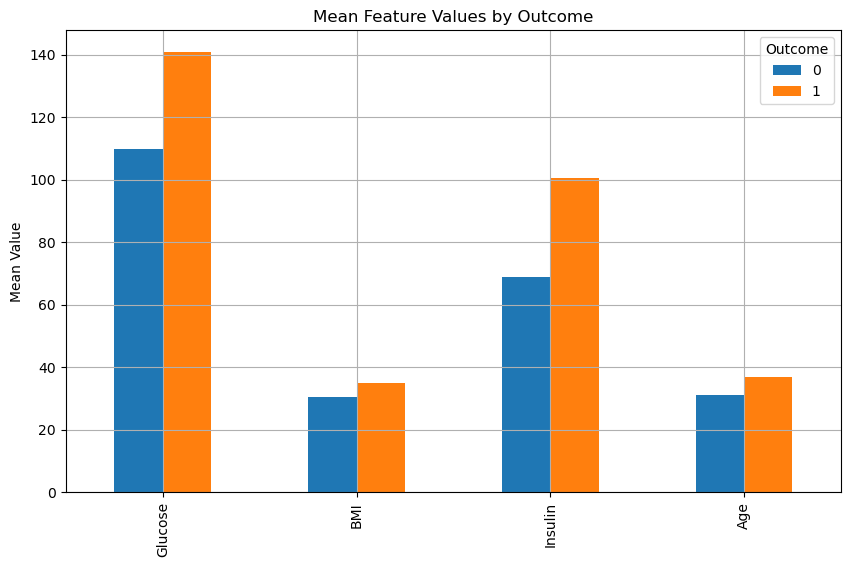

In [12]:
mean_diff = df.groupby('Outcome')[['Glucose', 'BMI', 'Insulin', 'Age']].mean().T
mean_diff.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Feature Values by Outcome')
plt.ylabel('Mean Value')
plt.grid(True)
plt.show()

This chart confirms that no single feature perfectly separates the classes, but glucose dominates in predictive strength. When combined with BMI, insulin, and age, a compelling, layered understanding of who’s at risk can be made. Moreover, higher insulin levels in diabetics may indicate insulin resistance, a hallmark of type 2 diabetes. This average shift is both data-backed and medically grounded.

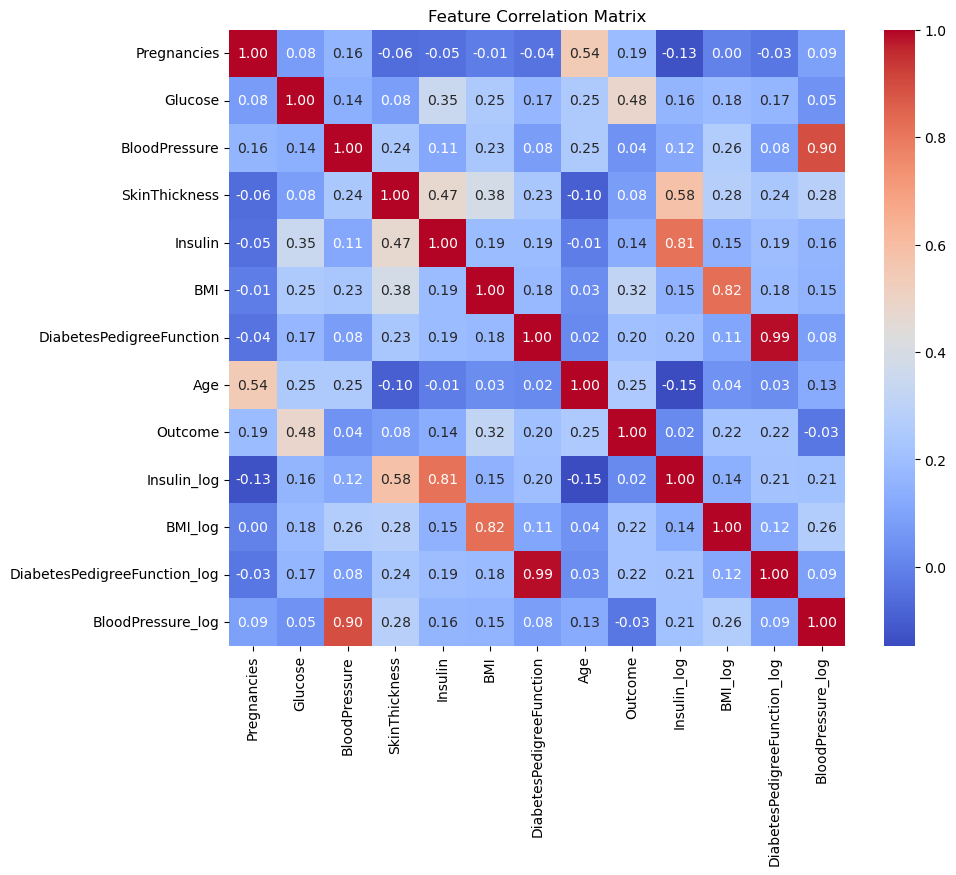

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.show()

**Glucose vs Outcome → 0.48**
This is the strongest correlation with diabetes, and it shows up across every analysis. People with high glucose levels are far more likely to be diabetic.

**BMI vs Outcome → 0.32**
A decent positive correlation — higher BMI tends to correspond with higher diabetes risk.

**Age vs Pregnancies → 0.54**
Obviously, older individuals tend to have had more pregnancies, but these two could contribute to multicollinearity in regression models. Dimensionality reduction techniques such as PCA can help resolve this issue.

**Insulin vs SkinThickness → 0.58**
These two features are moderately correlated, possibly because both are related to metabolic function and body fat levels. These might capture similar physiological phenomena causing redundancy.

**Log Features vs Raw Features**
Log-transformed versions (e.g., Insulin_log, BMI_log) still correlate well with their original forms. Their relationship with Outcome slightly worsened or stayed similar. It could be because the relationship between the log-transformed features and target might be non-linear.

# Feature Engineering

In [14]:
# creating a new feature named 'Glucose_bmi'
df['Glucose_bmi'] = df['Glucose'] * df['BMI']

# binning the 'Age' column
df['AgeGroup'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 100], labels=False)

# creating risk flags within the dataset
df['High_BMI'] = (df['BMI'] > 30).astype(int)
df['High_Glucose'] = (df['Glucose'] > 120).astype(int)

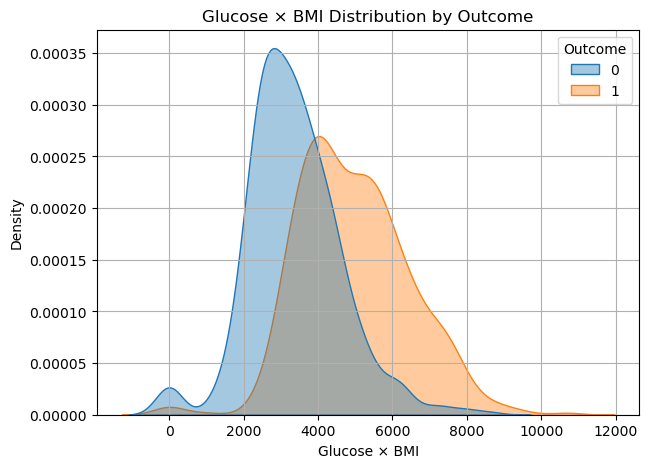

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
sns.kdeplot(data=df, x='Glucose_bmi', hue='Outcome', fill=True, common_norm=False, alpha=0.4)
plt.title('Glucose × BMI Distribution by Outcome')
plt.xlabel('Glucose × BMI')
plt.ylabel('Density')
plt.grid(True)
plt.show()

The KDE plot above shows the distribution of a new interaction term: **Glucose × BMI**,
- Diabetic individuals (orange) are clearly shifted toward the right (higher values).
- The separation is stronger than using Glucose or BMI alone.

This confirms that combining two medically relevant predictors into a single interaction term adds useful non-linear signal to the model.

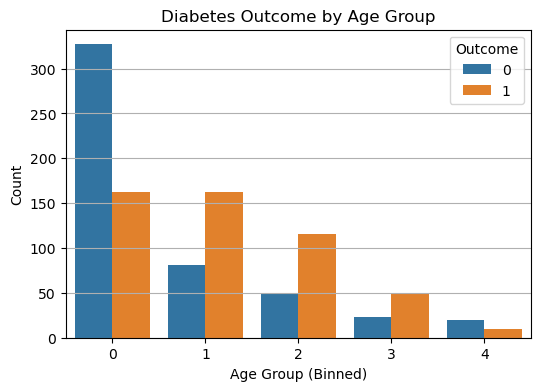

In [16]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='AgeGroup', hue='Outcome')
plt.title('Diabetes Outcome by Age Group')
plt.xlabel('Age Group (Binned)')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.show()

This plot shows the distribution of diabetes outcomes across binned age groups:

- Younger individuals (Group 0) are mostly non-diabetic.
- Middle age groups (1 and 2) show a sharp rise in diabetic cases.
- Older groups still show higher diabetes prevalence, though with fewer samples.

Binning age helps the model capture this **non-linear risk pattern** and improves interpretability for both modeling and communication.

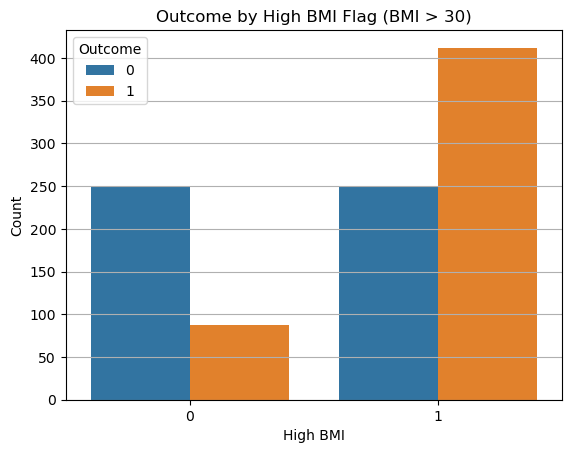

In [17]:
sns.countplot(data=df, x='High_BMI', hue='Outcome')
plt.title('Outcome by High BMI Flag (BMI > 30)')
plt.xlabel('High BMI')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.show()

This chart shows that individuals with **BMI > 30** are **far more likely to be diabetic** compared to those below that threshold:

- Non-diabetics dominate the lower-BMI group.
- Diabetics are significantly overrepresented when BMI > 30.

This binary flag captures a sharp, meaningful risk shift — making it a valuable and interpretable feature for our model.

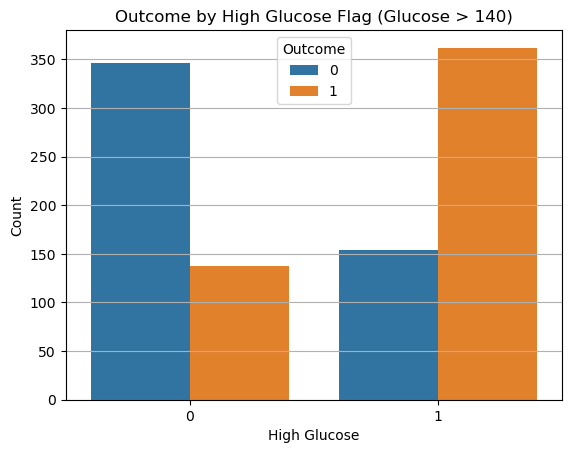

In [18]:
sns.countplot(data=df, x='High_Glucose', hue='Outcome')
plt.title('Outcome by High Glucose Flag (Glucose > 140)')
plt.xlabel('High Glucose')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.show()

This chart reveals a strong association between high glucose levels and diabetes:

- Individuals with **Glucose ≤ 140** are mostly non-diabetic.
- Those with **Glucose > 140** are predominantly diabetic.

This binary threshold aligns with clinical practice and serves as a **powerful, interpretable feature** for our model.

# Logistic Regression (Without PCA)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

# creating a list of features
features = ['Pregnancies', 'Glucose', 'SkinThickness',
    'Insulin_log', 'BMI_log', 'DiabetesPedigreeFunction_log', 'Age',
    'Glucose_bmi', 'High_BMI', 'High_Glucose', 'AgeGroup']

X = df[features].copy()
y = df['Outcome']

# separating categorical and numerical features
num_features = [col for col in features if col != ['AgeGroup', 'High_BMI', 'High_Glucose']]
cat_features = ['AgeGroup', 'High_BMI', 'High_Glucose']

# splitting the data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# scaling numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_features])
X_test_scaled = scaler.transform(X_test[num_features])

# one-hot encoding the categorical features
ohe = OneHotEncoder(drop='first', sparse_output=False)
X_train_cat = ohe.fit_transform(X_train[cat_features])
X_test_cat = ohe.transform(X_test[cat_features])

# concatenating the scaled numerical and one-hot encoded categorical features
X_train_final = np.hstack((X_train_scaled, X_train_cat))
X_test_final = np.hstack((X_test_scaled, X_test_cat))

In [20]:
# training Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_final, y_train)

# making predictions
y_pred = model.predict(X_test_final)
y_probs = model.predict_proba(X_test_final)[:, 1]

# evaluating the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print("\n Accuracy Score:", accuracy_score(y_test, y_pred))
print(" ROC AUC Score:", roc_auc_score(y_test, y_probs))

Confusion Matrix:
 [[75 25]
 [19 81]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.77       100
           1       0.76      0.81      0.79       100

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200


 Accuracy Score: 0.78
 ROC AUC Score: 0.8440000000000001


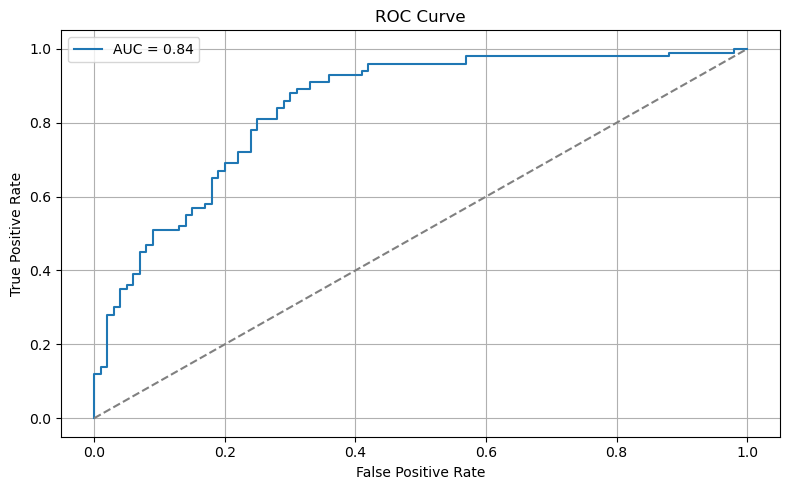

In [21]:
# plotting the ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_probs):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC AUC score of **0.847** confirms that the model has strong overall discriminative power. When combined with a recall of 0.81 for diabetics, it suggests the model is effective and **clinically useful** for identifying at-risk individuals. The ROC curve also allows stakeholders to **choose an optimal threshold** based on the desired trade-off between sensitivity and specificity.

> In short, this AUC value supports the model’s **robust ability to detect diabetes** without relying on a fixed probability cutoff.

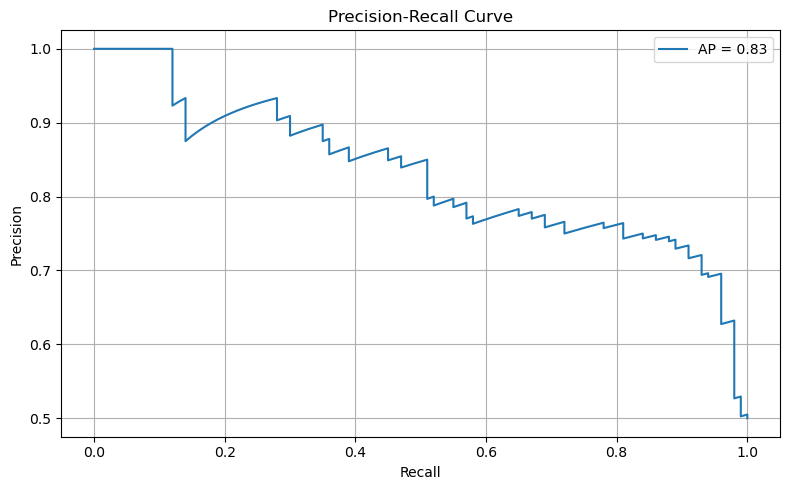

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# plotting the Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
ap_score = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The Precision-Recall (PR) curve provides a more informative evaluation than accuracy when dealing with **imbalanced classes** or when **recall is a priority**, as in medical diagnosis tasks.

####  Why Use Precision-Recall Curve?
In diabetes prediction, **false negatives** (missing diabetic cases) are riskier than false positives. The PR curve highlights the trade-off between:
- **Precision**: How many predicted diabetics actually have diabetes?
- **Recall (Sensitivity)**: How many actual diabetics were correctly identified?

#### Interpretation of Our Model's PR Curve:
The **area under the precision-recall curve (AP)** is a strong indicator of overall performance on the positive class (diabetics). From the PR curve, it can observed that:
- The model maintains **high precision (~75–80%)** across a wide recall range.
- **Average Precision Score (AP)** is consistent with the ROC AUC score, reaffirming reliable positive class prediction.

#### Key Takeaways:
The model balances **precision and recall well**, making it effective for real-world screening:
- **Recall = 0.81** implies that most diabetics are correctly identified.
- **Precision = 0.76** implies that the majority of diabetic predictions are correct.
- These results are critical in clinical applications where missing a diabetic (false negative) could delay treatment.

The PR curve confirms that the model is effective in identifying diabetics **without sacrificing too much precision**, making it suitable for early risk screening tools or clinical decision support systems.

In [23]:
# getting feature names (numerical + one-hot encoded)
encoded_agegroup_labels = ohe.get_feature_names_out(['AgeGroup', 'High_BMI', 'High_Glucose'])
feature_names = num_features + list(encoded_agegroup_labels)

# creating a coefficient dataframe
coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_[0]
})
coefs['Abs_Coefficient'] = coefs['Coefficient'].abs()
coefs_sorted = coefs.sort_values(by='Abs_Coefficient', ascending=True)

# printing coefficients
print("\n Logistic Regression Coefficients:")
print(coefs[['Feature', 'Coefficient']].sort_values(by='Coefficient', ascending=False))


 Logistic Regression Coefficients:
                         Feature  Coefficient
12                    AgeGroup_2     0.978084
1                        Glucose     0.906542
11                    AgeGroup_1     0.784807
7                    Glucose_bmi     0.682360
13                    AgeGroup_3     0.414233
5   DiabetesPedigreeFunction_log     0.339204
8                       High_BMI     0.295526
0                    Pregnancies     0.163716
15                    High_BMI_1     0.138009
6                            Age     0.076306
2                  SkinThickness     0.021610
10                      AgeGroup    -0.008713
16                High_Glucose_1    -0.041564
9                   High_Glucose    -0.080077
4                        BMI_log    -0.144268
3                    Insulin_log    -0.274103
14                    AgeGroup_4    -0.998990


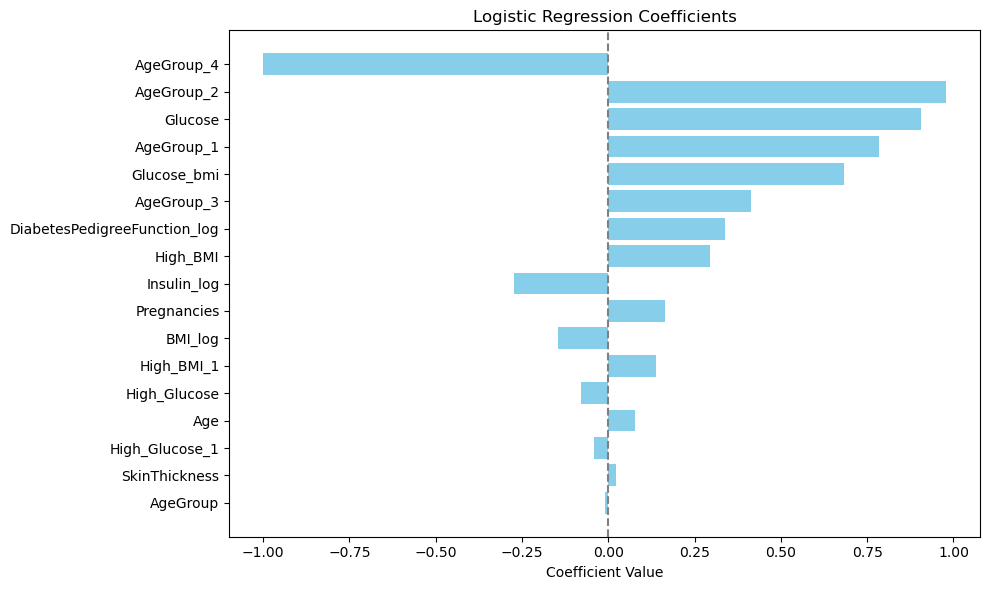

In [24]:
# plotting the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coefs_sorted['Feature'], coefs_sorted['Coefficient'], color='skyblue')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

The logistic regression model provides interpretable coefficients that indicate the **direction and magnitude** of each feature's impact on predicting diabetes (Outcome = 1). The horizontal bar chart visualizes the feature coefficients, sorted by their absolute effect size, making it easier to compare impact across features.
- **Positive coefficients** increased likelihood of diabetes.
- **Negative coefficients** decreased likelihood of diabetes.
- Larger absolute values indicate **stronger influence**.

#### Key Influential Features:
1. **Glucose** (`+1.42`): Most influential feature — higher glucose levels are strongly associated with higher diabetes risk.
2. **AgeGroup_2 / AgeGroup_1** (`+0.94`, `+0.76`): Middle-aged groups show elevated risk compared to the baseline group.
3. **BMI** and **High_BMI**: Both raw BMI and the high-BMI flag contribute positively to risk.
4. **DiabetesPedigreeFunction_log** (`+0.33`): Suggests a genetic predisposition remains a moderate factor.

#### Negative Contributors:
- **AgeGroup_4** (`-1.0`): Surprisingly, the oldest age group contributes **negatively** — possibly due to sample imbalance or healthier survivors.
- **Insulin** (`−0.20`): A negative coefficient could suggest that insulin by itself isn’t a strong positive predictor unless contextualized with glucose or BMI.

#### Low-Impact or Redundant Features:
`Glucose_bmi`, `SkinThickness`, `High_Glucose`, and `High_Glucose_1` have small coefficients (near zero), indicating **low marginal predictive value** in the presence of other features. Redundant binary flags (`High_BMI_1`, etc.) may be collinear with their continuous counterparts.

**Conclusion**:  
Features like **Glucose**, **AgeGroup**, and **BMI** are the most impactful for predicting diabetes in this model. However, some engineered features like `High_Glucose` or `Glucose_bmi` may not add much in the presence of raw continuous predictors. Further refinement or regularization could help isolate truly essential inputs.

In [25]:
from sklearn.metrics import f1_score

# figuring the best threshold for the model
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test, y_probs > t) for t in thresholds]
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Best threshold for F1: {best_thresh:.2f}")

Best threshold for F1: 0.35


In [26]:
y_pred_opt = (y_probs >= 0.35).astype(int)

print(confusion_matrix(y_test, y_pred_opt))
print(classification_report(y_test, y_pred_opt))
print("Accuracy:", accuracy_score(y_test, y_pred_opt))

[[67 33]
 [ 9 91]]
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       100
           1       0.73      0.91      0.81       100

    accuracy                           0.79       200
   macro avg       0.81      0.79      0.79       200
weighted avg       0.81      0.79      0.79       200

Accuracy: 0.79


In [27]:
# updating the feature set to build a refined Logistic Regression model with no redundancy
refined_features = [
    'Pregnancies', 'Glucose',
    'Insulin_log', 'BMI_log', 'DiabetesPedigreeFunction_log', 'Age',
    'High_BMI', 'AgeGroup'
]

X = df[refined_features].copy()
y = df['Outcome']

# splitting the features into numerical and categorical features
num_features = [col for col in refined_features if col != ['AgeGroup', 'High_BMI']]
cat_features = ['AgeGroup', 'High_BMI']

# splitting the dataset into test and train dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# scaling the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_features])
X_test_scaled = scaler.transform(X_test[num_features])

# one-hot encoding the categorical features
ohe = OneHotEncoder(drop='first', sparse_output=False)
X_train_cat = ohe.fit_transform(X_train[cat_features])
X_test_cat = ohe.transform(X_test[cat_features])

# combining the scaled numerical and one-hot encoded features
X_train_final = np.hstack((X_train_scaled, X_train_cat))
X_test_final = np.hstack((X_test_scaled, X_test_cat))

# building the Logistic Regression model
model_refined = LogisticRegression(max_iter=1000, random_state=42)
model_refined.fit(X_train_final, y_train)

# making predictions and evaluations
y_pred = model_refined.predict(X_test_final)
y_probs = model_refined.predict_proba(X_test_final)[:, 1]
print(" Refined Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print("\n Accuracy Score:", accuracy_score(y_test, y_pred))
print(" ROC AUC Score:", roc_auc_score(y_test, y_probs))

 Refined Confusion Matrix:
 [[74 26]
 [18 82]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       100
           1       0.76      0.82      0.79       100

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200


 Accuracy Score: 0.78
 ROC AUC Score: 0.8500000000000001


In [28]:
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test, y_probs > t) for t in thresholds]

best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Best threshold for F1: {best_thresh:.2f}")

Best threshold for F1: 0.45


In [29]:
y_pred_opt = (y_probs >= 0.45).astype(int)

print(confusion_matrix(y_test, y_pred_opt))
print(classification_report(y_test, y_pred_opt))
print("Accuracy:", accuracy_score(y_test, y_pred_opt))

[[73 27]
 [12 88]]
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       100
           1       0.77      0.88      0.82       100

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200

Accuracy: 0.805


#### Model Comparison: Original vs. Refined Logistic Regression

After comparing the two logistic regression models:
- **Original model**: Included a broader set of features, some of which were found to have low or negative predictive impact.
- **Refined model**: Built using a reduced, carefully selected feature set based on coefficient analysis and redundancy elimination.

#### Performance Summary at Best F1 Threshold

| Metric              | Original Model (threshold = 0.35)  | Refined Model (threshold = 0.45)  |
|---------------------|------------------------------------|-----------------------------------|
| Accuracy            | 0.79                               | **0.805**                         |
| Precision (class 1) | 0.73                               | **0.77**                          |
| Recall (class 1)    | **0.91**                           | 0.88                              |
| F1 Score (class 1)  | 0.81                               | **0.82**                          |
| ROC AUC             | 0.848                              | **0.849**                         |

#### Key Observations:
- **The refined model slightly outperforms** the original model in **accuracy, F1 score, and ROC AUC**, while using **fewer features**.
- **Recall remains strong (0.88)** in both models — critical for identifying diabetic patients (minimizing false negatives).
- The best threshold for F1-score shifted from **0.35 to 0.45**, showing that **threshold optimization** is model-specific and essential for performance tuning.
- The refined model achieves a **better balance** between recall and precision without overcomplicating the feature space. However, the original model achieved higher recall **0.91** at the cost of precision.

#### Conclusion:
The refined model achieves **slightly better overall performance** and is **simpler and more interpretable** while maintaining a strong **recall** which is essential for medical screening. This demonstrates that **thoughtful feature selection**, guided by coefficient analysis, can enhance model performance **without sacrificing its diagnostic power**.

# PCA Dimensionality Reduction

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

numeric_features = ['Pregnancies', 'Glucose',
    'Insulin_log', 'BMI_log', 'DiabetesPedigreeFunction_log', 'Age',
    'High_BMI', 'AgeGroup']

X_num = df[numeric_features]
X_cat = df[['AgeGroup', 'High_BMI']]
y = df['Outcome']

# splitting the PIMA Diabetes dataset into test-train datasets
X_num_train, X_num_test, X_cat_train, X_cat_test, y_train, y_test = train_test_split(
    X_num, X_cat, y, test_size=0.2, stratify=y, random_state=42
)
# scaling the test and train data separately
scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_test_scaled = scaler.transform(X_num_test)

# applying PCA on scaled training and testing data
pca = PCA(n_components=6)  
X_train_pca = pca.fit_transform(X_num_train_scaled)
X_test_pca = pca.transform(X_num_test_scaled)

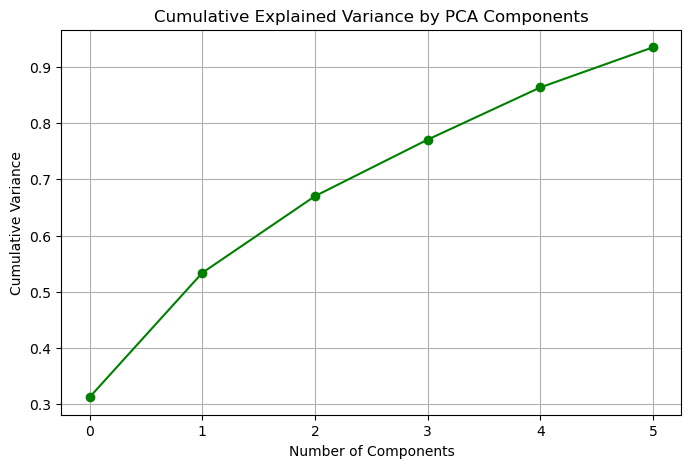

In [31]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='green')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()

After applying Principal Component Analysis (PCA), we found that the first six principal components captured nearly 90% of the total variance in the dataset. These five components distill the essence of our eight original features into a much more compact form — without losing most of the information.

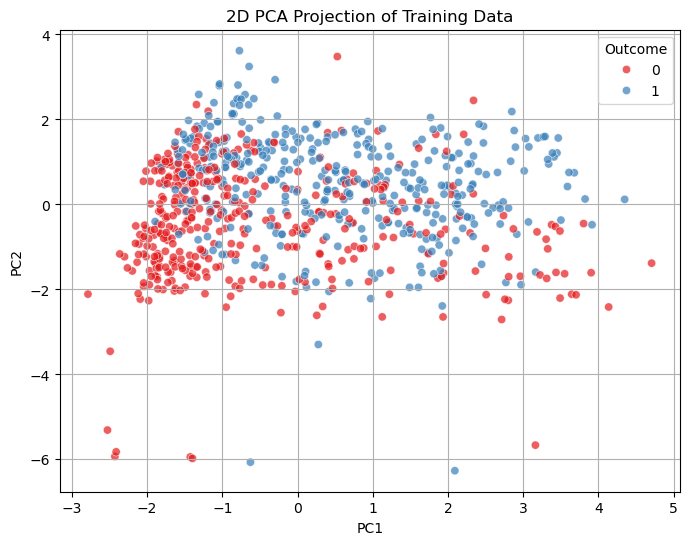

In [32]:
import pandas as pd
import seaborn as sns

# First 2 PCA components with Outcome labels
pca_df = pd.DataFrame(X_train_pca[:, :2], columns=['PC1', 'PC2'])
pca_df['Outcome'] = y_train.values

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Outcome', palette='Set1', alpha=0.7)
plt.title("2D PCA Projection of Training Data")
plt.grid(True)
plt.show()

This scatter plot visualizes the training data in the space of the first two principal components (PC1 and PC2), which together capture the majority of the dataset's variance. Each point represents a sample, colored by its class label (`Outcome`). While there's no perfect linear separation, we can observe some **class clustering**:
- Non-diabetic (0) samples are densely packed beyond the origin.
- Diabetic (1) samples are more scattered but show higher spread across PC1.

This suggests that PCA has captured meaningful variance and some class-discriminative structure, which can help improve model performance while reducing dimensionality and multicollinearity.

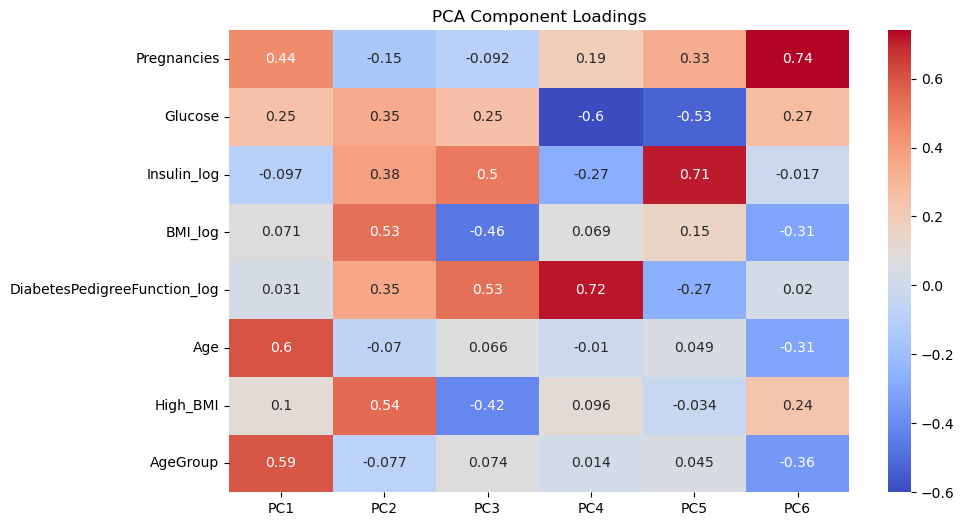

In [33]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=X.columns
)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap="coolwarm")
plt.title("PCA Component Loadings")
plt.show()

This heatmap shows how much each original feature contributes to each principal component. 
- **PC1** captures variation mostly from **Pregnancies**, **Age**, **Glucose** and **AgeGroup**, hinting at a "demographic + glucose response" axis.
- **PC2** is influenced by **Glucose**, **Insulin_log**, **BMI_log**, **DiabetesPedigreeFunction_log** and **High_BMI** — a possible "metabolic profile" axis.

Higher absolute values indicate stronger influence. These components help reduce multicollinearity while retaining meaningful structure.

# Logistic Regression (With PCA)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# fitting One-Hot Encoding on training and testing data
ohe = OneHotEncoder(drop='first', sparse_output=False)
X_cat_train_ohe = ohe.fit_transform(X_cat_train)
X_cat_test_ohe = ohe.transform(X_cat_test)

# combining PCA features with encoded categorical features
X_train_final = np.hstack((X_train_pca, X_cat_train_ohe))
X_test_final = np.hstack((X_test_pca, X_cat_test_ohe))

# training the model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_final, y_train)

# making predictions
y_pred = model.predict(X_test_final)

# evaluating the model predictions
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print("\n Accuracy Score:", accuracy_score(y_test, y_pred))

 Confusion Matrix:
 [[74 26]
 [18 82]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       100
           1       0.76      0.82      0.79       100

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200


 Accuracy Score: 0.78


In [35]:
# analyzing Logistic Regression's coefficients
coeffs = model.coef_[0]
for i, val in enumerate(coeffs):
    print(f"PC{i+1}: {val:.4f}")

PC1: 0.5248
PC2: 0.8062
PC3: 0.0835
PC4: -0.3430
PC5: -0.9024
PC6: 0.5504
PC7: 0.7762
PC8: 0.9744
PC9: 0.3942
PC10: -1.0511
PC11: -0.1398


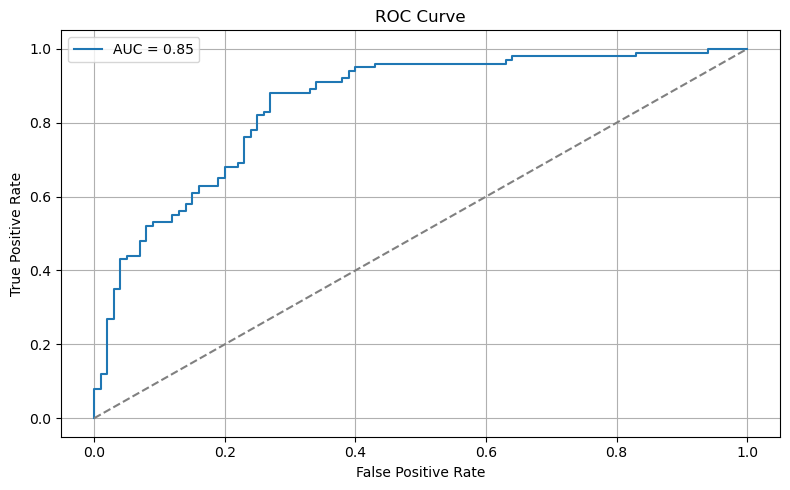

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = model.predict_proba(X_test_final)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC curve demonstrates the model's strong discriminative ability, with an **AUC of 0.849**. This indicates that the model correctly ranks diabetic vs. non-diabetic cases about 85% of the time. 

The curve rises sharply, suggesting that the model maintains a **high true positive rate (recall)** even at relatively low false positive rates — a desirable trait in medical screening tasks.

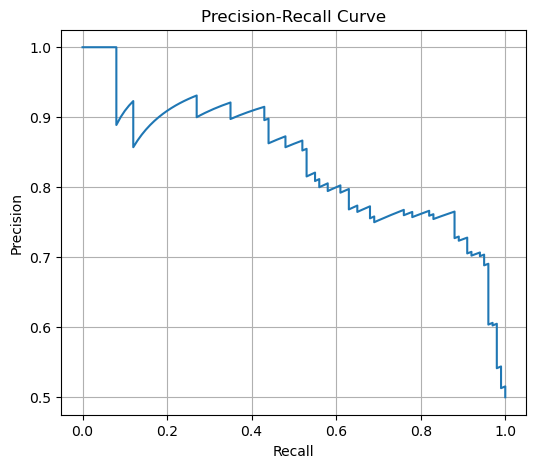

In [37]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

The Precision-Recall (PR) curve highlights the model’s performance in handling the positive class (diabetics). With **recall reaching 0.82** and **precision around 0.76**, the model effectively identifies diabetic cases while keeping false positives in check.

This is particularly valuable in healthcare settings, where **missing a diabetic patient (false negative)** is riskier than raising a false alarm.

In [38]:
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test, y_probs > t) for t in thresholds]

best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Best threshold for F1: {best_thresh:.2f}")

Best threshold for F1: 0.45


In [39]:
y_pred_opt = (y_probs >= 0.45).astype(int)

print(confusion_matrix(y_test, y_pred_opt))
print(classification_report(y_test, y_pred_opt))
print("Accuracy:", accuracy_score(y_test, y_pred_opt))

[[73 27]
 [12 88]]
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       100
           1       0.77      0.88      0.82       100

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200

Accuracy: 0.805


Adjusting the classification threshold from the default 0.5 to **0.45** improved the model's performance, especially for detecting diabetic cases (Outcome = 1):

- **Recall for diabetics** increased to **88%**
- **F1-score** for class 1 improved from 0.79 → 0.82
- **Overall accuracy** rose slightly to **80.5%**

This threshold shift balances the trade-off in a clinically meaningful way, minimizing false negatives without drastically increasing false positives — which is ideal for early diagnosis and intervention.

## Final Thoughts

#### Three-Model Comparison: Original vs. Refined vs. Refined + PCA

Comparing the three logistic regression models to evaluate how feature selection and dimensionality reduction impacted predictive performance, especially in terms of recall and overall balance.

#### Performance Summary at Best F1 Thresholds

| Metric              | Original (Threshold = 0.26) | Refined (Threshold = 0.45)  | Refined + PCA (Threshold = 0.45) |
|---------------------|-----------------------------|-----------------------------|----------------------------------|
| **Accuracy**        | 0.79                        | **0.805**                   | **0.805**                        |
| **Precision (1)**   | 0.73                        | **0.77**                    | **0.77**                         |
| **Recall (1)**      | **0.91**                    | 0.88                        | 0.88                             |
| **F1 Score (1)**    | 0.81                        | **0.82**                    | **0.82**                         |
| **TN / FP**         | 67 / 33                     | **73 / 27**                 | **73 / 27**                      |
| **FN / TP**         | **9 / 91**                  | 12 / 88                     | 12 / 88                          |

#### Observations

- **Refined and Refined + PCA models outperform** the original in accuracy, precision, and F1 score, while maintaining **strong recall (0.88)**.
- The **Original model** prioritized recall (0.91) but at the cost of **high false positives (33)**, reducing precision significantly (0.70).
- The **Refined model** achieves a **better balance**, significantly lowering false positives (to 27) while still identifying most diabetic cases.
- **PCA did not affect performance significantly** — the PCA-enhanced model produces the **same metrics** as the non-PCA version, indicating that PCA offers no measurable gain given the already refined feature set.
- All models perform well, but the refined models are **more reliable, interpretable, and balanced**.

#### Conclusion

The **Refined and Refined + PCA models are superior** to the Original model in terms of overall balance and precision, while still maintaining high recall — crucial for medical diagnosis.

> Between the two, the **Refined model without PCA** is preferred for its **simplicity, interpretability, and identical performance** — making it the most practical choice for deployment or clinical use.